In [291]:
#Import libraries
# import wandb
import data_processing
import torch
import pandas as pd
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import optim
import torchvision
import torch.nn.functional as F
from PIL import Image
from itertools import permutations
from pytorch_metric_learning import losses
import random
from torchsummaryX import summary

# Helpers

In [292]:
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

def show_pair(img1, img2, description, label = None):
    concatenated = torch.cat((img1, img2), 0)
    concatenated = torchvision.utils.make_grid(concatenated)

    if label:
        truth = '' if label else ' not'
        imshow(concatenated, f'is{truth} the same person')
    else:
        imshow(concatenated, description)

# Configuration

In [293]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
print(device)

progres_print_rate = 10

config = {
  'batch_size': 256,
  'epochs': 100,
  'learning_rate': 0.00003,
  'contrastive_loss_margin': 1,
  'pin_memory': False,
  'num_workers': 0,
  'model_path': './data/model/',
}

# wandb.init(project="my-test-project")

# wandb_config = {
#   'batch_size': config['batch_size'],
#   'epochs': config['epochs'],
#   'learning_rate': config['learning_rate'],
# }



cuda


# Data Loading

In [294]:
# 
# One positie one negative for each image
#
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.images_perm = list(permutations(imageFolderDataset.imgs,2))
        self.images = imageFolderDataset.imgs
        self.transform = transform
        self.index = 0
        
    
    def __getitem__(self, index):
        _tmp0 = self.images[self.index]
    
        iteration = index % 2
        self.index += iteration
        
        if iteration:
            while True:
                #Look untill the same class image is found
                _tmp1 = random.choice(self.images) 
                if _tmp0[1] == _tmp1[1] and _tmp0[0] != _tmp1[0]:
                    break
        else:
            while True:
                #Look untill a different class image is found
                _tmp1 = random.choice(self.images) 
                if _tmp0[1] != _tmp1[1]:
                    break
        
        img0 = Image.open(_tmp0[0])
        img1 = Image.open(_tmp1[0])

        # img0 = img0.convert("L")
        # img1 = img1.convert("L")
        
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            
        # Image 1, Image2, Label
        return img0, img1, torch.from_numpy(np.array([int(_tmp0[1] == _tmp1[1])], dtype=np.float64))
    
    def __len__(self):
        return (len(self.images) * 2)

In [295]:
# 
# 50:50 chance
#
class SiameseNetworkDatasetChance(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.images_perm = list(permutations(imageFolderDataset.imgs,2))
        self.images = imageFolderDataset.imgs
        self.transform = transform
        
    def __getitem__(self, index):
        _tmp0 = self.images[index]
        
        # ensure 50:50 chance of getting positive and negative pair
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                _tmp1 = random.choice(self.images) 
                if _tmp0[1] == _tmp1[1] and _tmp0[0] != _tmp1[0]:
                    break
        else:
            while True:
                #Look untill a different class image is found
                _tmp1 = random.choice(self.images) 
                if _tmp0[1] != _tmp1[1]:
                    break
        
        img0 = Image.open(_tmp0[0])
        img1 = Image.open(_tmp1[0])

        # img0 = img0.convert("L")
        # img1 = img1.convert("L")
        
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        # Image 1, Image2, Label
        return img0, img1, torch.from_numpy(np.array([int(_tmp0[1] == _tmp1[1])], dtype=np.float64))
    
    def __len__(self):
        return len(self.images)

In [296]:
# 
# Permutations
# 
class SiameseNetworkDatasetPerm(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.images_perm = list(permutations(imageFolderDataset.imgs,2))
        self.images = imageFolderDataset.imgs
        self.transform = transform   
    
    
    def __getitem__(self,index):
        img_tuple = self.images_perm[index]
        
        _tmp0 = img_tuple[0]
        _tmp1 = img_tuple[1]
        
        img0 = Image.open(_tmp0[0])
        img1 = Image.open(_tmp1[0])

        # img0 = img0.convert("L")
        # img1 = img1.convert("L")
        
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
            
        return img0, img1, torch.from_numpy(np.array([int(_tmp0[1] == _tmp1[1])], dtype=np.float64))
    
    def __len__(self):
        return len(self.images_perm)

In [297]:
transform = transforms.Compose([transforms.Resize((64,64)),
                                transforms.ToTensor()])

imageFolderDataset = datasets.ImageFolder('./data/faces2/training', transform=transform)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=imageFolderDataset, transform=transform)

train_dataset, val_dataset = train_test_split(siamese_dataset,  test_size = 0.2, shuffle=False)

train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], num_workers = config['num_workers'], pin_memory=config['pin_memory'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=True)

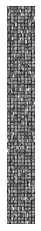

[1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0.
 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1.
 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0.
 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1.
 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.]


In [298]:
example_batch = next(iter(train_dataloader))

concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))


# Network

In [299]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Setting up the Sequential of CNN Layers
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=10,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=7,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(128, 128, kernel_size=4,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2, stride=2),
                        
            nn.Conv2d(128, 256, kernel_size=3,bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.Flatten()
        )

        # Setting up the Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(9216, 4096),
            nn.ReLU(inplace=True),
            
            nn.Linear(4096, 512),
            nn.ReLU(inplace=True),
            
            nn.Linear(512,1)
        )
        
    def _forward(self, x):

        output = self.cnn(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)

        return output

    def forward(self, input1, input2):

        output1 = self._forward(input1)
        output2 = self._forward(input2)
        
        return output1, output2

In [300]:
#create the Siamese Neural Network
class SiameseNetworkSteve(nn.Module):

    def __init__(self):
        super(SiameseNetworkSteve, self).__init__()
        
        # Setting up the Sequential of CNN Layers
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5),
            # nn.BatchNorm2d(64), 
            nn.ReLU(inplace=True),
            nn.AvgPool2d(2,2),
            nn.Dropout2d(0.2),
            
            # nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=4),
            # nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(2,2),
            nn.Dropout2d(0.2),

            # nn.MaxPool2d(2, stride=2),
            
            nn.Conv2d(128, 128, kernel_size=3),
            # nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(2,2),
            nn.Dropout2d(0.2),

            # nn.MaxPool2d(2, stride=2),
                        
            nn.Conv2d(128, 256, kernel_size=3),
            # nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AvgPool2d(2,2),
            nn.Dropout2d(0.2),
            
            nn.Flatten()
        )

        # Setting up the Fully Connected Layers
        self.fc = nn.Sequential(
            nn.Linear(256, 4096),
            
            nn.Sigmoid(),
            
            nn.Linear(4096,1),
            
            # nn.Sigmoid(),
        )
        
    def _forward(self, x):

        output = self.cnn(x)
        output = output.view(output.size()[0], -1)
        output = self.fc(output)

        return output

    def forward(self, input1, input2):

        output1 = self._forward(input1)
        output2 = self._forward(input2)
        
        return output1, output2

## Contrastive Loss

In [301]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=config['contrastive_loss_margin']):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Calculate the euclidian distance and calculate the contrastive loss
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                        (1-label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        
        return loss_contrastive

# Building Model

In [302]:
# Define model
net = SiameseNetworkSteve().to(device)
loss_fun = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = config['learning_rate'] )

# shape = tuple(next(iter(train_dataloader))[0].shape)
# input_shape = torch.zeros(shape)
# summary(net,input_shape,input2=input_shape)
# train_dataloader
# print(tuple(next(iter(train_dataloader))[0].shape)[1:])
print(net)

SiameseNetworkSteve(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): Dropout2d(p=0.2, inplace=False)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU(inplace=True)
    (10): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (11): Dropout2d(p=0.2, inplace=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU(inplace=True)
    (14): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (15): Dropout2d(p=0.2, inplace=False)
    (16): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=4096, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=4096, out_features=1, bias=True)
  )
)


# Learning

In [303]:
counter = []
loss_history = [] 
val_loss_history = [] 

def validate_model(dataloader, model, loss_fun):                       
    running_loss = 0.0
    model.eval()      
    with torch.no_grad():
        for index, (data1, data2, label) in enumerate(dataloader, 0):
            data1, data2, label = data1.to(device), data2.to(device), label.to(device)

            output1, output2 = model(data1, data2)
            loss = loss_fun(output1, output2, label)
            running_loss = running_loss + loss.item()
               
            # wandb.log({"val_loss": running_loss})
            # wandb.watch(model)
            
        return running_loss
def save_model():
    pass    
def learn_model(model, loss_fun, optimizer, train_dataloader, val_dataloader, num_epochs = config['epochs']):
    iteration_number= 0
    # Iterate throught the epochs
    for epoch in range(num_epochs):

        # Iterate over batches
        for index, (data1, data2, label) in enumerate(train_dataloader, 0):
            # Send the images and labels to CUDA
            data1, data2, label = data1.to(device), data2.to(device), label.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Pass in the two images into the network and obtain two outputs
            output1, output2 = model(data1, data2)

            # Pass the outputs of the networks and label into the loss function
            loss = loss_fun(output1, output2, label)

            # Calculate the backpropagation
            loss.backward()

            # Optimize
            optimizer.step()
            
            # wandb.log({"loss": loss})
            # wandb.watch(model)
            
            # Every 10 batches save the loss
            if index % 10 == 0 :
                iteration_number += 1
                
                val_loss = validate_model(dataloader=val_dataloader, model=model, loss_fun=loss_fun)
                
                counter.append(iteration_number)
                loss_history.append(loss.item())
                val_loss_history.append(val_loss)
       
        # Every progres_print_rate epoch repoty the loss and val_loss
        if (epoch + 1) % progres_print_rate == 0 :
            print(f'Epoch number {epoch + 1}')
            print(f'\tCurrent loss {loss.item()}')
            print(f'\tValidation Loss: {val_loss}')
            print('-----------------------------------------------------------')
            torch.save({
                'epoch':epoch+1,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict':optimizer.state_dict(),
                'loss': loss,
            }, config['model_path'] + f'model_{epoch+1}.pt')
            
            

In [304]:

learn_model(net, loss_fun, optimizer, train_dataloader, val_dataloader, config['epochs'])


Epoch number 10
	Current loss 0.4832344643802735
	Validation Loss: 0.4843570893950003
-----------------------------------------------------------
Epoch number 20
	Current loss 0.26969963724166107
	Validation Loss: 0.29720322563945284
-----------------------------------------------------------
Epoch number 30
	Current loss 0.16192946815119696
	Validation Loss: 0.2146474039862966
-----------------------------------------------------------
Epoch number 40
	Current loss 0.16069236813409415
	Validation Loss: 0.2168479303528462
-----------------------------------------------------------
Epoch number 50
	Current loss 0.17882086183835172
	Validation Loss: 0.2070421221083292
-----------------------------------------------------------
Epoch number 60
	Current loss 0.15881013956813952
	Validation Loss: 0.20456727211746353
-----------------------------------------------------------
Epoch number 70
	Current loss 0.19133678187503078
	Validation Loss: 0.20213681320043075
-----------------------------

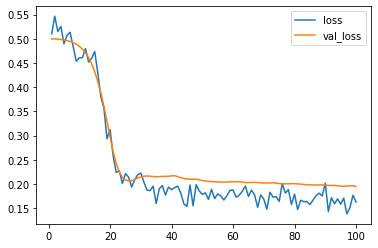

In [305]:
plt.plot(counter, loss_history,label = "loss")
plt.plot(counter, val_loss_history,label = "val_loss")
plt.legend()
plt.show()

In [306]:

torch.save(net.state_dict(), config['model_path'] + 'model.pt')


In [307]:
# checkpoint = torch.load(config['model_path'] + 'model_100.pt')
# net.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']
# net.eval()

In [308]:
net.load_state_dict(torch.load(config['model_path'] + 'model.pt'))
net.eval()

SiameseNetworkSteve(
  (cnn): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (7): Dropout2d(p=0.2, inplace=False)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU(inplace=True)
    (10): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (11): Dropout2d(p=0.2, inplace=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (13): ReLU(inplace=True)
    (14): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (15): Dropout2d(p=0.2, inplace=False)
    (16): Flatten(start_dim=1, end_dim=-1)
  )
  (fc): Sequential(
    (0): Linear(in_features=256, out_features=4096, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=4096, out_features=1, bias=True)
  )
)

In [309]:
# # Locate the test dataset and load it into the SiameseNetworkDataset
# folder_dataset_test = datasets.ImageFolder(root="./data/faces2/testing/")
# siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
#                                         transform=transform)
# test_dataloader = DataLoader(siamese_dataset, batch_size=1, shuffle=True)

# for i in range(21):
#     lowest_eu = []
#     lowest_conc = []
#     # Grab one image that we are going to test
#     dataiter = iter(test_dataloader)
#     x0, _, _ = next(dataiter)

#     for i in range(20):
#         # Iterate over 10 images and test them with the first image (x0)
#         _, x1, label2 = next(dataiter)

#         # Concatenate the two images together
#         concatenated = torch.cat((x0, x1), 0)
#         concatenated = torchvision.utils.make_grid(concatenated)
#         # print(concatenated.type)
#         output1, output2 = net(x0.to(device), x1.to(device))
#         euclidean_distance = F.pairwise_distance(output1, output2)

#         if euclidean_distance.item() > float(0.05):
#             lowest_eu.append(euclidean_distance.item())
#             lowest_conc.append(concatenated)
            
#     euclidean_distance=lowest_eu[lowest_eu.index(min(lowest_eu))]
#     concatenated=lowest_conc[lowest_eu.index(min(lowest_eu))]
#     imshow(concatenated, f'Dissimilarity: {euclidean_distance:.2f}')

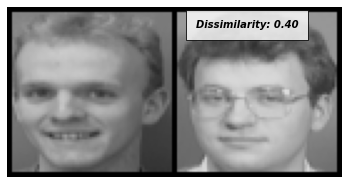

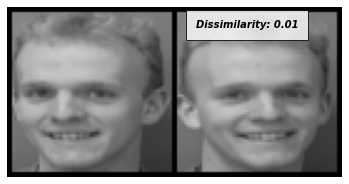

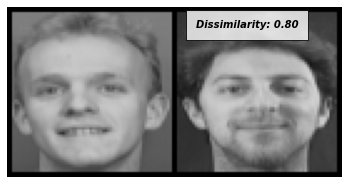

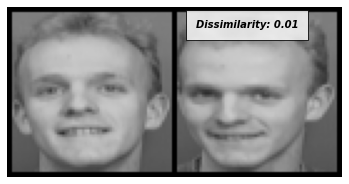

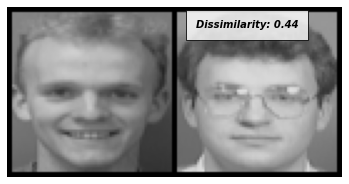

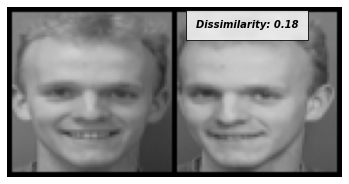

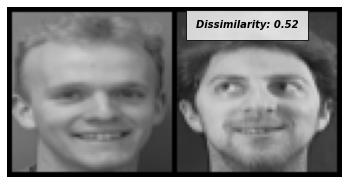

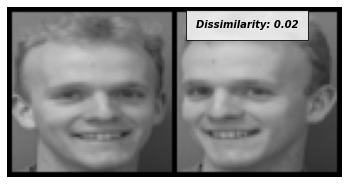

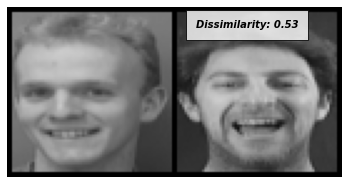

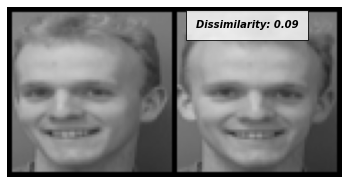

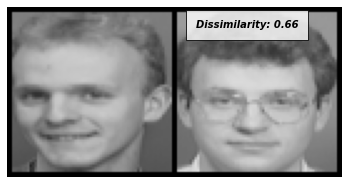

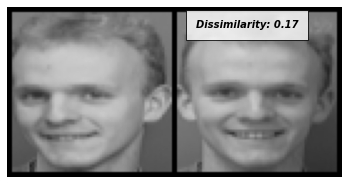

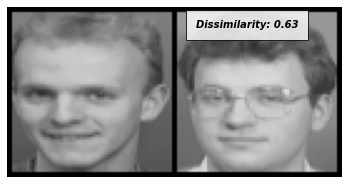

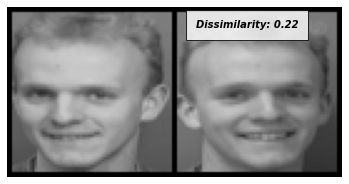

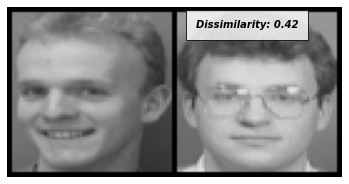

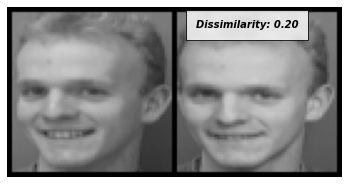

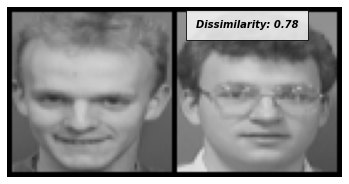

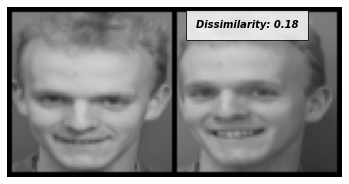

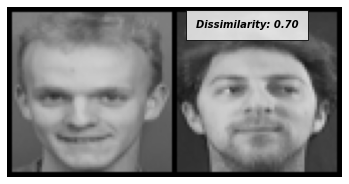

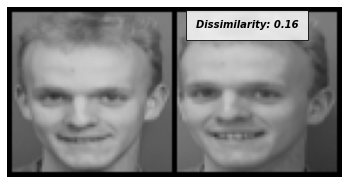

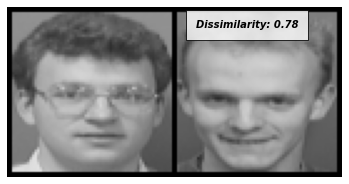

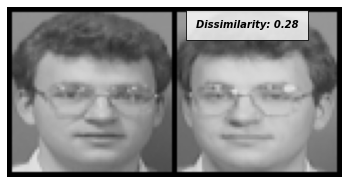

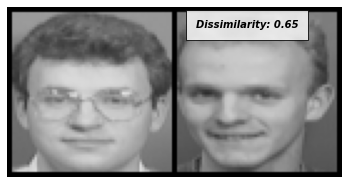

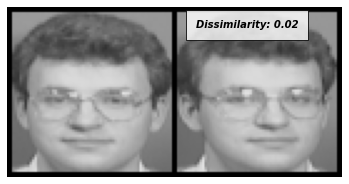

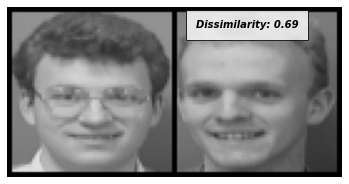

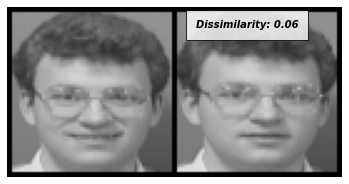

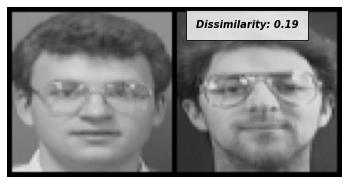

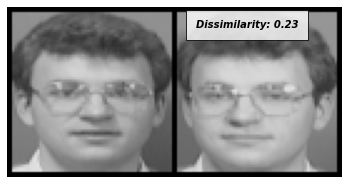

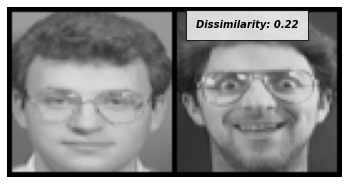

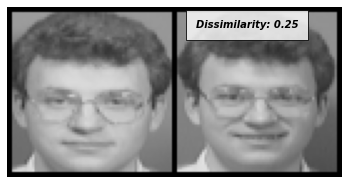

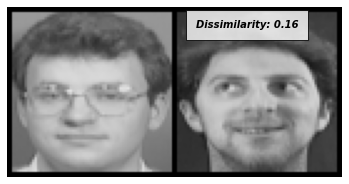

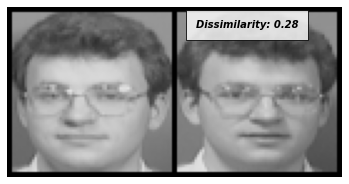

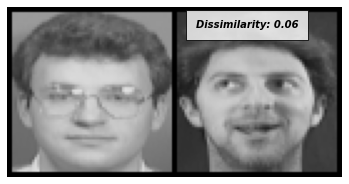

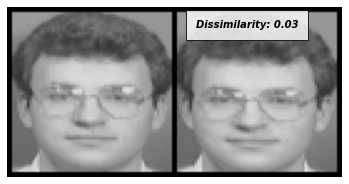

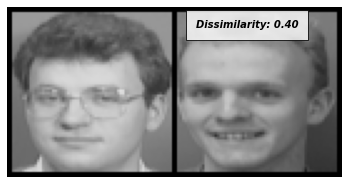

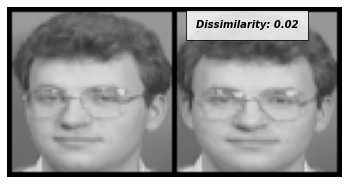

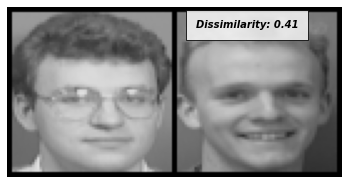

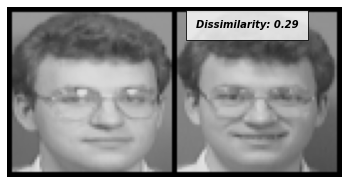

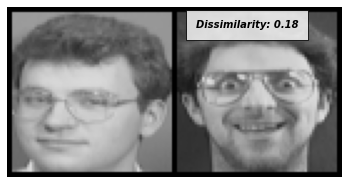

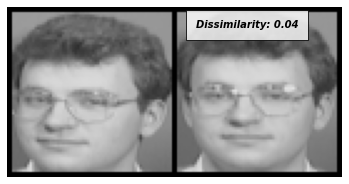

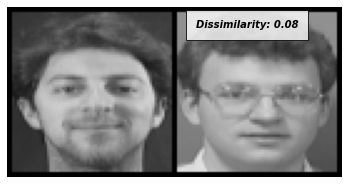

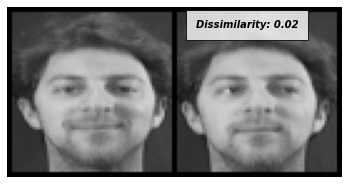

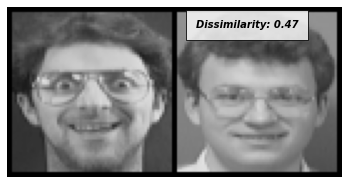

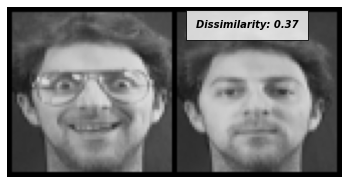

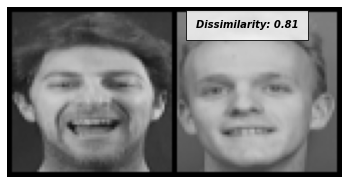

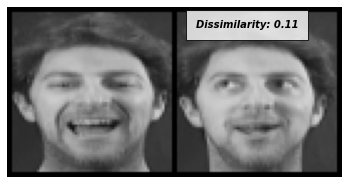

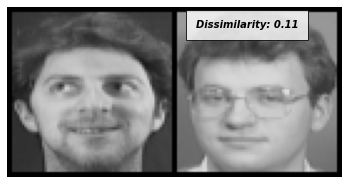

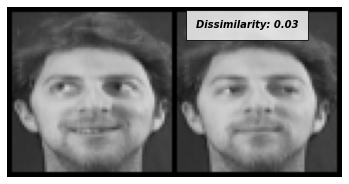

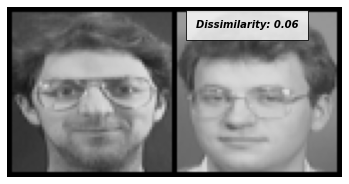

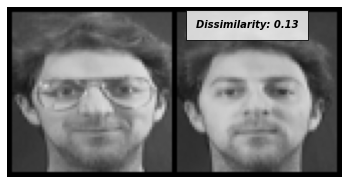

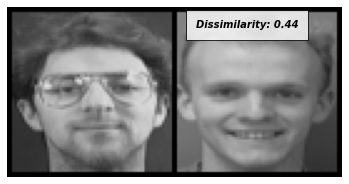

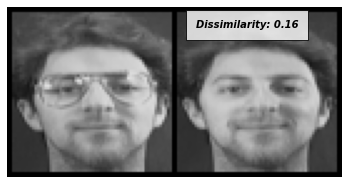

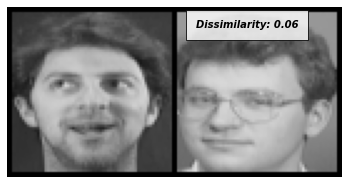

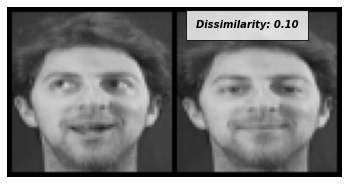

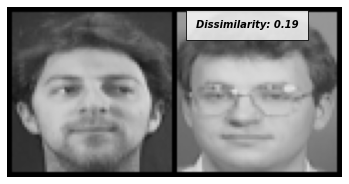

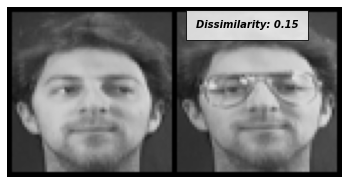

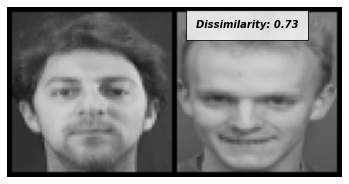

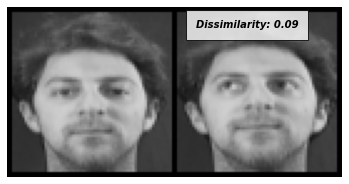

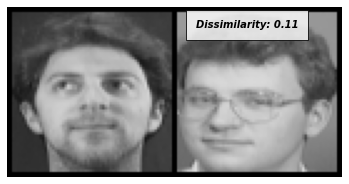

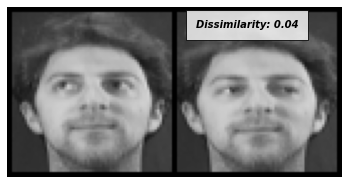

In [310]:
folder_dataset_test = datasets.ImageFolder(root="./data/faces/testing/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transform)
test_dataloader = DataLoader(siamese_dataset, batch_size=1, shuffle=False)


# Grab one image that we are going to test
dataiter = iter(test_dataloader)

for x0, x1, label2 in dataiter:
    # Iterate over 10 images and test them with the first image (x0)
    
    output1, output2 = net(x0.to(device), x1.to(device))
    euclidean_distance = F.pairwise_distance(output1, output2)

    show_pair(x0, x1, f'Dissimilarity: {euclidean_distance.item():.2f}')